This is the second installment of the Heart Failure Prediction Analysis.
Previously, we inspected the dataset and preprocessed the features for the classification task.
In this part we'll try out a few different classifiers, optimise them and chain them up into an
ensemble classifier. Finally, we'll evaluate its performance on the test set and we'll save the
algorithm for future applications (e.g. a Web app).

[Dataset in Kaggle](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data)

[Paper](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5): Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020).  

# Load The Dataset

Let's load the cleaned up dataset from the previous step and make a sanity
check it's alright.

In [1]:
import joblib
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

FIG_DIR = "../flask/static"

In [2]:
df = joblib.load("df.pkl")

In [3]:
df.head()

,Age [years],Anaemia,Creatine Phosphokinase [mcg/L],Diabetes,Ejection Fraction [%],High Blood Pressure,Platelets [1000 platelets/mL],Serum Creatinine [mg/dL],Serum Sodium [mEq/L],Male,Smoking,Time [days],DEATH_EVENT
0,75.0,0,582,0,20,1,265.00000,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263.35803,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162.00000,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210.00000,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327.00000,2.7,116,0,0,8,1


In [4]:
df.shape

(299, 13)

We can see everything is as expected:
- there is 299 patients like previously
- column names include units and better formatting

# Split the data into train and test sets
It is time to split the dataset into train and test sets.
As explained in the previous post, we're going to select the patients 
in the following categories:
- **survivors**: survived _at least_ the first $100$ days
- **deceased** ones: passed away _within_ the first $100$ days

In [5]:
def select_df(n=100):
    """Select the patients that survived / didn't the first n days"""
    select = (((df['DEATH_EVENT'] == 0) & (df['Time [days]'] > n)) |
              ((df['DEATH_EVENT'] == 1) & (df['Time [days]'] < n)))
    return df[select]


df = select_df()

# Remove not useful features
df = df.drop(["Time [days]"], axis=1)
df.head()

,Age [years],Anaemia,Creatine Phosphokinase [mcg/L],Diabetes,Ejection Fraction [%],High Blood Pressure,Platelets [1000 platelets/mL],Serum Creatinine [mg/dL],Serum Sodium [mEq/L],Male,Smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265.00000,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263.35803,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162.00000,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210.00000,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327.00000,2.7,116,0,0,1


In [6]:
df.shape

(219, 12)

There are $219$ patients in this category.
It's a small statistics, which implies a few things:
- If we split train/test set in the $60\%/40\%$ ratio, we'll end up with
  around $130$ and $90$ patients in the respective categories
- It's likely to overtrain a model given a big number of features relative to the dataset size

To tackle the problem, we must rely on a simple classifier, perhaps with reduced
number of features.

Let's proceed step-by-step, starting with splitting the dataset into the
train and test sets in the $60\%/40\%$ ratio.

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.4, random_state=42)
train_set['DEATH_EVENT'].value_counts()

0    88
1    43
Name: DEATH_EVENT, dtype: int64

We end up with $88$ surviving and $43$ deceased patients in the training set.

Now, we'll separate the features from the labels.

In [8]:
# drop labels and time for training set
X_train = train_set.drop(["DEATH_EVENT"], axis=1)
y_train = train_set["DEATH_EVENT"].copy()
# drop labels and time for test set
X_test = test_set.drop(["DEATH_EVENT"], axis=1)
y_test = test_set["DEATH_EVENT"].copy()

# Scale features and make a pipeline

Many algorithms require all parameters to be of the same scale.
More precisely, the features might be _normalised_ by mapping onto the $[0,1]$
range, or _standardised_ by subtracting the mean and dividing by the
standard deviation, making sure the results will have unit variance.

The former might be preferable for neural networks that require $[0, 1]$-range
input. The latter, on the other hand, are less impacted by the outliers.
Since we'll be focused on simpler classifiers _standardisation_ should be
a better choice.

Moreover, we'll put the scaling procedure in a pipeline for easier
reproducibility. Were there more preprocessing steps needed, we would
add them in the pipeline as well.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [10]:
pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

X_train_tr = pipeline.fit_transform(X_train)

In [11]:
X_train_tr

array([[-1.13454396, -0.83743579, -0.05671184, ..., -0.62481182,
         0.72336423, -0.6990253 ],
       [-0.46342344, -0.83743579,  0.16941911, ...,  0.75082429,
         0.72336423,  1.4305634 ],
       [ 0.20769707,  1.1941214 ,  1.00243904, ...,  0.06300623,
         0.72336423, -0.6990253 ],
       ...,
       [-0.88287377, -0.83743579, -0.4741156 , ..., -0.62481182,
         0.72336423,  1.4305634 ],
       [-0.21175325, -0.83743579, -0.45892103, ...,  0.5215516 ,
         0.72336423, -0.6990253 ],
       [ 0.20769707,  1.1941214 , -0.05671184, ...,  0.06300623,
         0.72336423,  1.4305634 ]])

That was just a technical check. We'll actually use standardisation later on.

# Dimensionality Reduction with PCA

To simplify the model, perhaps some features can be skipped with no big loss
to the performance and increased generalisation.
To this end we'll use the Principal Component Analysis (PCA) that projects
the features onto hyperplanes preserving most of the variance. Each successive plane is orthogonal to the previous ones and has the largest remaining variance of the dataset. Intuitively, the bigger the variance, the better resolution we have to then separate instances of various classes. Moreover, it is common sense that the remaining variance must be 'hidden' in the orthogonal planes, whose projections carry way too compressed information (e.g. projecting the $y-$axis onto the $x-$axis results in a single point; not much information).

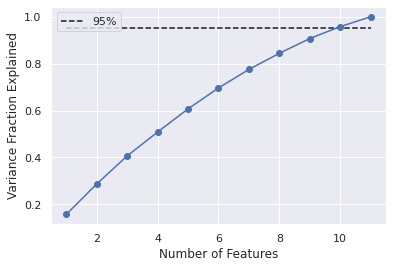

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
# It's important to standardise features before PCA
# or else features that are just big will artificially have big variance.
pca.fit(X_train_tr)

def plot_explained_variance():
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum)+1), cumsum, 'o-')
    plt.xlabel("Number of Features")
    plt.ylabel("Variance Fraction Explained")
    n_features = X_train_tr.shape[1]
    plt.hlines(y=0.95, xmin=1, xmax=n_features, linestyles='dashed',
               color='k', label='95%')
    plt.legend(loc='best')
plot_explained_variance()

We can see that 10 features are required to preserve $95\%$ of the total variance.
This could be obtained more directly, but without visualisation as follows.

In [13]:
pca = PCA(n_components=0.95)

pca.fit_transform(X_train_tr)
pca.components_.T.shape # 11 x 10 matrix -> reduce to 10 dimensions

(11, 10)

Later on, we'll use PCA in a grid search to find whether it helps improve
the results and, if so, how many components are useful.

# Logistic Regression Classifier
Since we don't have much data, it's better to focus on simple classifiers.
Otherwise, we risk overtraining.

Logistic regression is one of the simplest classifiers.
Let's go directly to the hyperparameter tuning.

In [14]:
from sklearn.linear_model import LogisticRegression

## Hyperparameter Tuning and Regularisation

These hyperparameter questions we want to find answers to with a help of the grid search:
- Whether to use PCA or not; if so, how many components?
- Regularisation: Ridge ($\ell_2$), Lasso ($\ell_1$) or Elastic Net (in-between)
- Class weight: shall the class imabalance be accounted for by attributing bigger weights to less common class (i.e. patients that passed away)?
- Which solver to use in the training algorithm? This depends:
  - liblinear is good for small datasets
  - Elastic Net is supported only by the saga solver

Besides, how many folds should be used in $k-$fold validation?
Since in each iteration the model is trained on $k-1$ folds and tested on the remaining one,
to ensure the test is reliable, we'd better not reduced it too much.
Therefore, splitting our roughly $120$ patients into $2-3$ folds should be the upper limit.

The **metric** we want to optimise should not be accuracy as it is sensitive
to the class imbalance. Instead, precision and recall seem more pertinant, or their harmonic average, $F_1 = \frac{2}{1/P + 1/R}$, where $P$ and $R$ stand for precision and recall respectively and are computed as:
precision = $TP / (TP + FP)$ ("purity" of the positive-labeled group)
and recall = $TP / (TP + FN)$ (i.e. "have we labeled all the positive guys as such?").

In [15]:
# Let's optimise Logistic Regression
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('std_scaler', StandardScaler()),    
    ('pca', PCA()),
    ('clf', LogisticRegression()),
])

param_grid = [
    {'pca': ['passthrough', PCA(1), PCA(3), PCA(9), PCA(10), PCA(11)],
     'clf__penalty': ['l2', 'l1'],
     'clf__C': [.1, .5, .75, 1.0, 1.25, 1.50, 1.75, 2.0],
     'clf__class_weight': [None, 'balanced'],
     'clf__solver': ['liblinear'],  # good for small datasets
     'clf__random_state': [42]
     },
    # Elastic net is only supported by the ‘saga’ solver
    # and it requires l1_ratio parameter.
    {'pca': ['passthrough', PCA(1), PCA(3), PCA(9), PCA(10), PCA(11)],
     'clf__penalty': ['elastic_net'],
     'clf__C': [.1, .5, .75, 1.0, 1.25, 1.50, 1.75, 2.0],
     'clf__class_weight': [None, 'balanced'],
     'clf__solver': ['saga'],
     'clf__l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
     'clf__random_state': [42]
     }
]
grid_search = GridSearchCV(pipeline, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 768 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1159 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed:    2.9s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.1, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0],
                          'clf__class_weight': [None, 'balanced'],
                          'clf__penalty': ['l2', 'l1'],
                          'clf__random_state': [42],
                          'clf__solver': ['liblinear'],
                          'pca': ['passthrough', PCA(n_components=1),
                                  P...
                         {'clf__C': [0.1, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0],
                          'clf__class_weight': [None, 'balanced'],
                          'clf__l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
                          'clf__penalty': ['elastic_net'],
                          'clf__random_state': [42]

In [16]:
grid_search.best_params_

{'clf__C': 0.75,
 'clf__class_weight': None,
 'clf__penalty': 'l1',
 'clf__random_state': 42,
 'clf__solver': 'liblinear',
 'pca': 'passthrough'}

In [17]:
log_clf = grid_search.best_estimator_
log_clf

Pipeline(steps=[('std_scaler', StandardScaler()), ('pca', 'passthrough'),
                ('clf',
                 LogisticRegression(C=0.75, penalty='l1', random_state=42,
                                    solver='liblinear'))])

It turns out we'd better skipped the PCA (`passthrough`) and exploit all the features.

In [18]:
def best_score(grid_search):
    res = pd.DataFrame(grid_search.cv_results_)
    argmax = res['mean_test_score'].argmax()
    max_score = res['mean_test_score'].iloc[argmax]
    max_score_std = res['std_test_score'].iloc[argmax]
    return max_score, max_score_std


def print_best_score(grid_search):
    x, xerr = best_score(grid_search)
    print("Best score: {:.2f} +/- {:.2f}".format(x, xerr))


print_best_score(grid_search)

Best score: 0.61 +/- 0.04


In [19]:
y_train[:5]

223    0
179    0
200    0
2      1
133    0
Name: DEATH_EVENT, dtype: int64

In [20]:
grid_search.predict(X_train[:5])

array([0, 0, 0, 0, 0])

In [21]:
grid_search.predict_proba(X_train[:5])

array([[0.91306971, 0.08693029],
       [0.90287657, 0.09712343],
       [0.90405834, 0.09594166],
       [0.56134208, 0.43865792],
       [0.87130834, 0.12869166]])

The fourth patient was predicted as likely to survive despite actually
passing away. Looking at the probablities, though, the classifier attributed
only $56\%$ chance of surviving. Quite 'on the fence' regarding the 
limited statistics. Not bad! Of course, it's merely a technical check up, since
we used the train set.

# Random Forest Classifier

Random Forests are very powerful ensemble classifiers based on the Decision Trees.
Let's see how they will perform.

In [22]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [23]:
pipeline = Pipeline([
    #('time_bin', TimeBinning(bin_size=30)),
    ('std_scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'clf__n_estimators': [2, 10, 20, 21, 22, 30, 50],
     'clf__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    },
]

grid_search = GridSearchCV(pipeline, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11],
                          'clf__n_estimators': [2, 10, 20, 21, 22, 30, 50]}],
             return_train_score=True, scoring='f1')

In [25]:
grid_search.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_features=5, n_estimators=50,
                                        random_state=42))])

In [26]:
grid_search.best_params_

{'clf__max_features': 5, 'clf__n_estimators': 50}

It seems 5 features seem to be optimal for the classifier.

In [27]:
print_best_score(grid_search)

Best score: 0.61 +/- 0.06


In [28]:
feature_importances = \
    grid_search.best_estimator_._final_estimator.feature_importances_

Text(0.5, 0, 'Score')

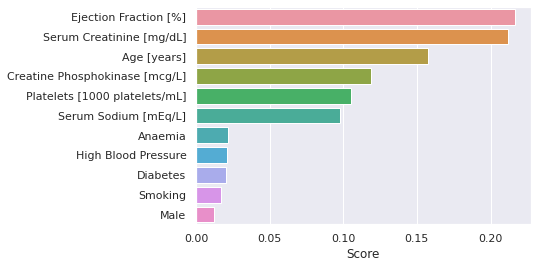

In [29]:
features_ranking = sorted(zip(
    [col for col in df.columns if col != 'DEATH_EVENT'], feature_importances),
                          reverse=True,
                          key=lambda x: x[1])

features = [x[0] for x in features_ranking]
ranks = [x[1] for x in features_ranking]

sns.barplot(y=features, x=ranks, orient='h')
plt.xlabel('Score')

In [30]:
best_features = features[:grid_search.best_params_['clf__max_features']]
rf_clf = grid_search.best_estimator_

In [31]:
y_train[:5]

223    0
179    0
200    0
2      1
133    0
Name: DEATH_EVENT, dtype: int64

In [32]:
rf_clf.predict_proba(X_train_tr[:5])[:, 1]

array([0.42, 0.42, 0.44, 0.42, 0.46])

Curiously, the probablities are close to $50\%$. It means the classifier might be really indecisive (perhaps under-trained?). If it's not necessary, it might be better to use a simpler classifier(s) of similar performance.

# SVM

Support Vector Machines (SVM) are quite simple classifiers that work well with small datasets.
We'll try first the SVM with linear kernel as it's simpler.
Then, with the 'rbf' (Radial Basis Function) kernel that is more suitable for non-linearly-separable data.

In [33]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=1, loss='hinge')),
    #('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])

param_grid = [{
    'svm_clf__penalty' : ['l1', 'l2'],
    'svm_clf__loss' : ['squared_hinge'],
    'svm_clf__C' : [0.1, 0.5, 1.0, 1.5],
    'svm_clf__class_weight' : ['balanced', None],
},
    {
    'svm_clf__penalty' : ['l2'],
    'svm_clf__loss' : ['hinge'],
    'svm_clf__C' : [0.1, 0.5, 1.0, 1.5],
    'svm_clf__class_weight' : ['balanced', None],   
}]
grid_search = GridSearchCV(svm_pipe, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print_best_score(grid_search)

{'svm_clf__C': 0.5, 'svm_clf__class_weight': None, 'svm_clf__loss': 'squared_hinge', 'svm_clf__penalty': 'l2'}
Best score: 0.62 +/- 0.03


In [34]:
# SVM with rbf kernel
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC()),
])

param_grid = [{
    'svm_clf__C' : [0.1, 0.5, 1.0, 1.5],
    'svm_clf__kernel': ['rbf', 'poly', 'sigmoid', 'precomputed'],
    'svm_clf__degree': [2, 3, 4],
    'svm_clf__gamma': ['scale', 'auto'],
    'svm_clf__coef0': [0.0, 0.1, 0.2],
    'svm_clf__class_weight' : ['balanced', None],
    'svm_clf__probability' : [True],
}]
grid_search = GridSearchCV(svm_pipe, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print_best_score(grid_search)

{'svm_clf__C': 1.5, 'svm_clf__class_weight': 'balanced', 'svm_clf__coef0': 0.0, 'svm_clf__degree': 2, 'svm_clf__gamma': 'scale', 'svm_clf__kernel': 'rbf', 'svm_clf__probability': True}
Best score: 0.67 +/- 0.01


Let's keep the best SVM with the 'rbf'-kernel as its score is better than of the linear one.

In [35]:
svm_clf = grid_search.best_estimator_

# KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier as KNNClassifier
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn_clf', KNNClassifier())
])

param_grid = {
    'knn_clf__n_neighbors' : [1, 2, 3, 5],
    'knn_clf__weights' : ['uniform', 'distance'],
}

grid_search = GridSearchCV(knn_pipe, param_grid, cv=2,
                           scoring='f1',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn_clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn_clf__n_neighbors': [1, 2, 3, 5],
                         'knn_clf__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1')

In [37]:
grid_search.best_params_

{'knn_clf__n_neighbors': 1, 'knn_clf__weights': 'uniform'}

In [38]:
print_best_score(grid_search)

Best score: 0.37 +/- 0.08


In [39]:
knn_clf = grid_search.best_estimator_

The KNN classifier has really poor performance. Let's abandon it.

# Chaining up the Classifiers

To make the most out of each classifier, we may combine them into a single one.
This is akin to voting in all sorts of whimsical _crowd wisdom_ questions (who on earth cares how many beans you have in your jar xD).

We'll be using _soft_ voting that takes into account confidence of each vote, rather than just the majority.

In [40]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), 
                ('rf', rf_clf),   # Doesn't help if LR and SVM are used!
                ('svm', svm_clf),
                ('knn', knn_clf), # makes the results worse! Excluded.
               ],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('std_scaler', StandardScaler()),
                                              ('pca', 'passthrough'),
                                              ('clf',
                                               LogisticRegression(C=0.75,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear'))])),
                             ('rf',
                              Pipeline(steps=[('std_scaler', StandardScaler()),
                                              ('clf',
                                               RandomForestClassifier(max_features=5,
                                                                      n_estimators=50,
                                                                      random_state=42))])

Just for fun (and curiosity) let's implement a coin-toss classifier
to later compare it with the other ones.

In [41]:
from sklearn.base import BaseEstimator
class CoinTossClassifier(BaseEstimator):
    def fit(self, X, y=None):
        """Nothing to fit"""
        return self
    def predict(self, X):
        """Toss a coin"""
        return np.random.randint(0, 2, size=len(X))
coin_clf = CoinTossClassifier()
(coin_clf.predict(X_test) == y_test).value_counts()

True     46
False    42
Name: DEATH_EVENT, dtype: int64

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

sns.color_palette("dark")
from sklearn.metrics import accuracy_score
metrics = {}
for name, clf in zip(('logit', 'RF', 'SVM', 'KNN', 'Ensemble', 'Coin Toss'),
                     (log_clf, rf_clf, svm_clf, knn_clf, voting_clf, coin_clf)):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    metrics[name] = {}
    for metric in (f1_score, precision_score, recall_score, accuracy_score):
        metrics[name][metric.__name__] = metric(y_test, y_pred)
df_metrics = pd.DataFrame(metrics)
df_metrics

,logit,RF,SVM,KNN,Ensemble,Coin Toss
f1_score,0.551724,0.461538,0.666667,0.400000,0.509091,0.468750
precision_score,0.533333,0.500000,0.560976,0.375000,0.518519,0.416667
recall_score,0.571429,0.428571,0.821429,0.428571,0.500000,0.535714
accuracy_score,0.704545,0.681818,0.738636,0.590909,0.693182,0.613636


<AxesSubplot:>

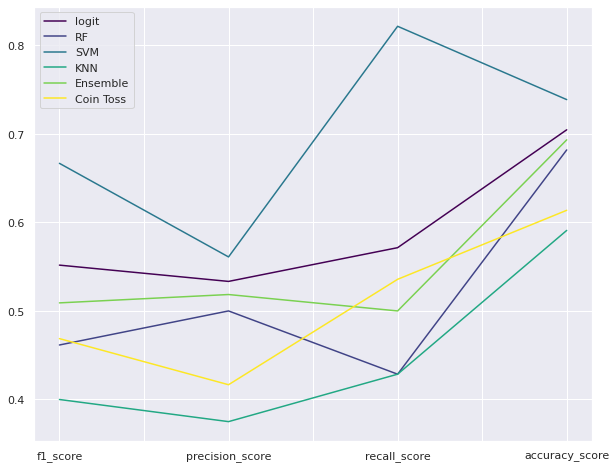

In [43]:
df_metrics.plot(figsize=(10, 8), cmap='viridis')

# Conclusion

Perhaps surprisingly, the best performance in all metrics is achieved by the SVM algorithm.
The second place goes to the logistic regression classifier.
Only then, appears the ensemble classifier!
It seems reasonable that the simple algorithms outperform more complex ones when we have statistically-limited data.


Let's use then the **SVM classifier**.

Now, let's think about the big picture of the heart failure prediction issue.
The ultimate question about the project is: how the algorithm output will be used?
If doctors will implement extra safety precautions for the deemed-dead patients, perhaps it's
better to be overcautious by optimising for higher recall, thereby raising false alarms.

On the other hand, if the doctors might apply a potentially dangerous operation, we'd better kept $F_1$ score high instead.

Therefore, **domain knowledge** and the **context** of the machine-learning problem are essential.

# Appendix 1: Save the model

In [44]:
final_model = svm_clf

In [45]:
df.columns

Index(['Age [years]', 'Anaemia', 'Creatine Phosphokinase [mcg/L]', 'Diabetes',
       'Ejection Fraction [%]', 'High Blood Pressure',
       'Platelets [1000 platelets/mL]', 'Serum Creatinine [mg/dL]',
       'Serum Sodium [mEq/L]', 'Male', 'Smoking', 'DEATH_EVENT'],
      dtype='object')

In [46]:
from collections import OrderedDict
import joblib
joblib.dump(svm_clf, "cardio_model.pkl")
features = df.columns[:-1]
joblib.dump(features, "cardio_features.pkl")

['cardio_features.pkl']

# Appendix 2: Load the model

In [47]:
# Test the model on hypothetical new cases
model = joblib.load("cardio_model.pkl")

In [48]:
model.predict(X_train[:5])

array([0, 0, 0, 1, 0])

In [49]:
model.predict_proba(X_train[:5])

array([[0.8790294 , 0.1209706 ],
       [0.95870944, 0.04129056],
       [0.87906009, 0.12093991],
       [0.24512301, 0.75487699],
       [0.87910504, 0.12089496]])